## 1. Setup and Data Loading

In [1]:
# !pip install pandas numpy==1.24.0 matplotlib seaborn scikit-learn nltk sentence-transformers
# Additional installations if needed:
# !pip install FuzzyTM blosc2 cython langchain==0.3.8 langsmith==0.1.125

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD
from math import sqrt
from sklearn.metrics import mean_squared_error


In [2]:
data = pd.read_csv('data/song_dataset.csv')
data.head()


,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


## 2. Data Preprocessing and Feature Engineering

In [3]:
print(data.isnull().sum())
data = data.dropna(subset=['genre', 'len', 'danceability', 'loudness', 
                           'acousticness', 'instrumentalness', 'valence', 'energy', 'lyrics'])


Unnamed: 0                  0
artist_name                 0
track_name                  0
release_date                0
genre                       0
lyrics                      0
len                         0
dating                      0
violence                    0
world/life                  0
night/time                  0
shake the audience          0
family/gospel               0
romantic                    0
communication               0
obscene                     0
music                       0
movement/places             0
light/visual perceptions    0
family/spiritual            0
like/girls                  0
sadness                     0
feelings                    0
danceability                0
loudness                    0
acousticness                0
instrumentalness            0
valence                     0
energy                      0
topic                       0
age                         0
dtype: int64


In [5]:
le_genre = LabelEncoder()
data['genre_encoded'] = le_genre.fit_transform(data['genre'])


In [6]:
numerical_features = [
    'len', 'danceability', 'loudness', 'acousticness', 
    'instrumentalness', 'valence', 'energy',
    'dating', 'violence', 'world/life', 'romantic', 
    'sadness', 'feelings'
]

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


## 3. Baseline Content-Based Recommendations (KNN)

In [7]:
features = numerical_features + ['genre_encoded']
X = data[features].values

knn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn_model.fit(X)

def recommend_songs(song_title, data, model, n_recommendations=5):
    idx = data[data['track_name'].str.lower() == song_title.lower()].index
    if idx.empty:
        print(f"Song '{song_title}' not found in the dataset.")
        return []
    idx = idx[0]
    song_features = X[idx].reshape(1, -1)
    distances, indices = model.kneighbors(song_features, n_neighbors=n_recommendations+1)
    recommendations = []
    for i in range(1, len(indices.flatten())):
        rec_idx = indices.flatten()[i]
        recommendations.append({
            'track_name': data.iloc[rec_idx]['track_name'],
            'artist_name': data.iloc[rec_idx]['artist_name'],
            'distance': distances.flatten()[i]
        })
    return recommendations


In [8]:
test_song = "future" 
recs = recommend_songs(test_song, data, knn_model)
print(f"Recommendations for '{test_song}':")
for rec in recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Similarity: {1 - rec['distance']:.4f})")


Recommendations for 'future':
- cole world by j. cole (Similarity: 0.9831)
- police state by tropidelic (Similarity: 0.9827)
- hustlaz ambition by jeezy (Similarity: 0.9812)
- how many times? by insane clown posse (Similarity: 0.9812)
- r by a$ap rocky (Similarity: 0.9811)


## 4. User Preference Simulation

In [9]:
users_df = pd.read_csv('data/users.csv')
def generate_initial_preferences(user_id, num_preferences=5):
    random_songs = data.sample(n=num_preferences)
    prefs = []
    for _, song in random_songs.iterrows():
        prefs.append({
            'user_id': user_id,
            'track_name': song['track_name'],
            'artist_name': song['artist_name'],
            'rating': np.random.randint(3, 6),
            'timestamp': pd.Timestamp.now()
        })
    return prefs

all_preferences = []
for user_id in users_df['User_id']:
    all_preferences.extend(generate_initial_preferences(user_id))
preferences_df = pd.DataFrame(all_preferences)


## 5. User-Centric Recommendations (Integrating Preferences)

In [10]:
def get_user_recommendations(user_id, preferences_df, data, model, n_recommendations=5):
    user_prefs = preferences_df[preferences_df['user_id'] == user_id]
    if user_prefs.empty:
        print(f"No preferences found for user {user_id}")
        return []
    
    all_recommendations = []
    for _, pref in user_prefs.iterrows():
        recs = recommend_songs(pref['track_name'], data, model)
        all_recommendations.extend(recs)
    
    # Deduplicate and sort by similarity
    seen = set()
    unique_recs = []
    for rec in all_recommendations:
        if rec['track_name'] not in seen:
            seen.add(rec['track_name'])
            unique_recs.append(rec)
    
    return sorted(unique_recs, key=lambda x: x['distance'])[:n_recommendations]

test_user_id = users_df['User_id'].iloc[0]
user_recs = get_user_recommendations(test_user_id, preferences_df, data, knn_model, 10)
print(f"\nUser-Centric Recommendations for '{test_user_id}':")
for rec in user_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Similarity: {1 - rec['distance']:.4f})")



User-Centric Recommendations for '12-685-2499':
- high flyin' by nick colionne (Similarity: 0.9781)
- tokyo by the brothers johnson (Similarity: 0.9776)
- queen bitch by lil' kim (Similarity: 0.9766)
- the way it is by tesla (Similarity: 0.9733)
- who put all my ex's in texas by willie nelson (Similarity: 0.9713)
- coolie boy by don drummond (Similarity: 0.9701)
- across the universe by david bowie (Similarity: 0.9653)
- right time by the expendables (Similarity: 0.9620)
- got to get a knutt by the new birth (Similarity: 0.9605)
- i'm the man by anthrax (Similarity: 0.9584)


## 6. Contextual Recommendations (Time-of-Day)

In [11]:
users_df['AgeGroup'] = np.random.choice(['Under 18', '18-24', '25-34', '35-44', '45+'], size=len(users_df))

def assign_preferred_genre(age_group):
    age_genre_map = {
        'Under 18': ['pop', 'hip hop', 'electronic'],
        '18-24': ['pop', 'hip hop', 'electronic', 'alternative'],
        '25-34': ['rock', 'pop', 'alternative', 'country'],
        '35-44': ['rock', 'country', 'jazz', 'blues'],
        '45+': ['classical', 'jazz', 'blues', 'country']
    }
    return np.random.choice(age_genre_map.get(age_group, data['genre'].unique()))

users_df['PreferredGenre'] = users_df['AgeGroup'].apply(assign_preferred_genre)

# Generate a rich listening history reflecting user preferences
listening_history = []
for _, user in users_df.iterrows():
    user_id = user['User_id']
    preferred_genre = user['PreferredGenre']
    num_songs = np.random.randint(50, 200)
    
    preferred_songs = data[data['genre'] == preferred_genre]
    if len(preferred_songs) == 0:
        preferred_genre = np.random.choice(data['genre'].unique())
        preferred_songs = data[data['genre'] == preferred_genre]
    
    num_preferred_songs = min(int(num_songs * 0.8), len(preferred_songs))
    num_other_songs = min(num_songs - num_preferred_songs, len(data) - len(preferred_songs))
    
    preferred_indices = preferred_songs.sample(n=num_preferred_songs, replace=True).index
    other_indices = data[data['genre'] != preferred_genre].sample(n=num_other_songs, replace=True).index
    song_indices = np.concatenate([preferred_indices, other_indices])
    np.random.shuffle(song_indices)
    
    for idx in song_indices:
        days_ago = np.random.randint(0, 30)
        listen_date = pd.Timestamp('today') - pd.Timedelta(days=days_ago)
        listening_history.append({
            'UserID': user_id,
            'SongID': data.iloc[idx]['track_name'],
            'ArtistName': data.iloc[idx]['artist_name'],
            'ListenDate': listen_date,
            'Rating': np.random.randint(1, 6)
        })

listening_history_df = pd.DataFrame(listening_history)
listening_history_df['hour'] = listening_history_df['ListenDate'].dt.hour

merged = listening_history_df.merge(data[['track_name', 'genre']], left_on='SongID', right_on='track_name', how='left')
hour_genre_rating = merged.groupby(['hour', 'genre']).agg({'Rating': 'mean'}).reset_index()

def time_of_day_recommendations(current_hour, data, hour_genre_rating, n_recommendations=5):
    hour_data = hour_genre_rating[hour_genre_rating['hour'] == current_hour]
    if hour_data.empty:
        top_genre = np.random.choice(data['genre'].unique())
    else:
        top_genre = hour_data.sort_values('Rating', ascending=False)['genre'].iloc[0]

    genre_songs = data[data['genre'] == top_genre]
    if len(genre_songs) == 0:
        return []

    recs = genre_songs.sample(min(n_recommendations, len(genre_songs)))[['track_name', 'artist_name', 'genre']]
    return recs.to_dict('records')

tod_recs = time_of_day_recommendations(21, data, hour_genre_rating, n_recommendations=5)
print("\nTime-of-Day Recommendations (21:00):")
for rec in tod_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']})")



Time-of-Day Recommendations (21:00):
- sunshine in the music by jimmy cliff (Genre: reggae)
- somewhere by freddie mcgregor (Genre: reggae)
- de-stress (acoustic) by rebelution (Genre: reggae)
- 144,000 by tribal seeds (Genre: reggae)
- garden of daisies by one drop (Genre: reggae)


## 7. Mood Classification (Decision Tree)

In [12]:
data['topic'] = data['topic'].astype(str)
topic_le = LabelEncoder()
data['topic_encoded'] = topic_le.fit_transform(data['topic'])

X_mood = data[numerical_features + ['genre_encoded']].values
y_mood = data['topic_encoded'].values

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_mood, y_mood, test_size=0.2, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_clf.fit(X_train_m, y_train_m)

y_pred_m = dt_clf.predict(X_test_m)
print("Mood Classification Report:")
print(classification_report(y_test_m, y_pred_m, target_names=topic_le.classes_))

def get_mood_recommendations(mood_label, data, topic_le, dt_model, n_recommendations=5):
    if mood_label not in topic_le.classes_:
        print(f"Mood '{mood_label}' not recognized.")
        return []
    mood_encoded = topic_le.transform([mood_label])[0]
    mood_songs = data[data['topic_encoded'] == mood_encoded]
    if mood_songs.empty:
        return []
    recs = mood_songs.sample(min(n_recommendations, len(mood_songs)))[['track_name', 'artist_name', 'genre', 'topic']]
    return recs.to_dict('records')

sad_recs = get_mood_recommendations('sadness', data, topic_le, dt_clf, n_recommendations=5)
print("\nSadness Mood Recommendations:")
for rec in sad_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']}, Topic: {rec['topic']})")


Mood Classification Report:
              precision    recall  f1-score   support

    feelings       1.00      0.95      0.98       130
       music       0.47      0.47      0.47       494
  night/time       0.35      0.02      0.03       361
     obscene       0.65      0.85      0.74       997
    romantic       0.95      0.98      0.97       297
     sadness       0.98      1.00      0.99      1197
    violence       0.99      0.99      0.99      1155
  world/life       0.98      0.99      0.99      1044

    accuracy                           0.86      5675
   macro avg       0.80      0.78      0.77      5675
weighted avg       0.84      0.86      0.84      5675


Sadness Mood Recommendations:
- somebody else's heart by lady antebellum (Genre: country, Topic: sadness)
- gentle on my mind by john hartford (Genre: country, Topic: sadness)
- someone else's star by bryan white (Genre: country, Topic: sadness)
- when my heart finds christmas by harry connick, jr. (Genre: jazz, Topic:

## 8. Genre Classification (Naive Bayes)

In [13]:
X_genre = data[numerical_features + ['topic_encoded']].values
y_genre = data['genre_encoded'].values

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_genre, y_genre, test_size=0.2, random_state=42, stratify=y_genre)
gnb = GaussianNB()
gnb.fit(X_train_g, y_train_g)

y_pred_g = gnb.predict(X_test_g)
print("Naive Bayes Classification Report:")
print(classification_report(y_test_g, y_pred_g, target_names=le_genre.classes_))

def get_genre_based_recommendations(desired_genre, data, le_genre, n_recommendations=5):
    if desired_genre not in le_genre.classes_:
        print(f"Genre '{desired_genre}' not recognized.")
        return []
    genre_encoded = le_genre.transform([desired_genre])[0]
    genre_songs = data[data['genre_encoded'] == genre_encoded]
    recs = genre_songs.sample(min(n_recommendations, len(genre_songs)))[['track_name', 'artist_name', 'genre', 'topic']]
    return recs.to_dict('records')

genre_recs = get_genre_based_recommendations('pop', data, le_genre, n_recommendations=5)
print("\nGenre-Based Recommendations (pop):")
for rec in genre_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']}, Topic: {rec['topic']})")


Naive Bayes Classification Report:
              precision    recall  f1-score   support

       blues       0.32      0.11      0.17       921
     country       0.34      0.62      0.44      1089
     hip hop       0.14      0.76      0.24       181
        jazz       0.43      0.29      0.35       769
         pop       0.36      0.11      0.17      1408
      reggae       0.39      0.34      0.36       500
        rock       0.35      0.43      0.39       807

    accuracy                           0.32      5675
   macro avg       0.33      0.38      0.30      5675
weighted avg       0.35      0.32      0.30      5675


Genre-Based Recommendations (pop):
- thinkin bout you by frank ocean (Genre: pop, Topic: obscene)
- punky's dilemma by simon & garfunkel (Genre: pop, Topic: obscene)
- afraid by the neighbourhood (Genre: pop, Topic: sadness)
- the order of death by public image ltd. (Genre: pop, Topic: night/time)
- take my hand for a while by glen campbell (Genre: pop, Topic: sadn

## 9. Collaborative Filtering (KNN User-Based & SVD)

### Knn User-based

In [14]:
user_encoder = LabelEncoder()
song_encoder = LabelEncoder()

listening_history_df['UserID_encoded'] = user_encoder.fit_transform(listening_history_df['UserID'])
listening_history_df['SongID_encoded'] = song_encoder.fit_transform(listening_history_df['SongID'])

user_item_matrix = listening_history_df.pivot_table(index='UserID_encoded', columns='SongID_encoded', values='Rating', aggfunc='mean').fillna(0)
knn_user = NearestNeighbors(metric='cosine', algorithm='brute')
knn_user.fit(user_item_matrix)

def recommend_songs_to_user(user_id, user_item_matrix, model, n_recommendations=5):
    user_idx = user_encoder.transform([user_id])[0]
    user_vector = user_item_matrix.loc[user_idx].values.reshape(1, -1)
    distances, indices = model.kneighbors(user_vector, n_neighbors=6)
    similar_users = indices.flatten()[1:]
    similar_users_songs = listening_history_df[listening_history_df['UserID_encoded'].isin(similar_users)]
    user_songs = set(listening_history_df[listening_history_df['UserID_encoded'] == user_idx]['SongID_encoded'])
    recommendations = similar_users_songs[~similar_users_songs['SongID_encoded'].isin(user_songs)]
    top_recommendations = recommendations.groupby('SongID_encoded').agg({'Rating': 'mean'}).sort_values('Rating', ascending=False).head(n_recommendations)
    recommended_song_ids = top_recommendations.index
    recommended_songs = song_encoder.inverse_transform(recommended_song_ids)
    result = []
    for sid in recommended_songs:
        song_data = data[data['track_name'] == sid].iloc[0]
        result.append({
            'track_name': song_data['track_name'],
            'artist_name': song_data['artist_name'],
            'average_rating': top_recommendations.loc[song_encoder.transform([sid])[0]]['Rating'],
            'genre': song_data['genre']
        })
    return result

test_user_id = users_df['User_id'].iloc[0]
user_cf_recs = recommend_songs_to_user(test_user_id, user_item_matrix, knn_user, n_recommendations=5)
print(f"\nKNN User-Based CF for '{test_user_id}':")
for rec in user_cf_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Avg Rating: {rec['average_rating']:.2f}, Genre: {rec['genre']})")



KNN User-Based CF for '12-685-2499':
- 從不喜歡孤單一個 by 彭家麗 (Avg Rating: 5.00, Genre: pop)
- the little man who wasn't there by glenn miller (Avg Rating: 5.00, Genre: jazz)
- drafted again by frank zappa (Avg Rating: 5.00, Genre: jazz)
- i'm free (heaven helps the man ) by kenny loggins (Avg Rating: 5.00, Genre: pop)
- the queen and the soldier by suzanne vega (Avg Rating: 5.00, Genre: pop)


#### SVD Factorization

In [15]:
n_factors = 50
svd = TruncatedSVD(n_components=n_factors, random_state=42)
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_.T

def svd_recommendations(user_id, user_item_matrix, user_factors, item_factors, song_encoder, data, n_recommendations=5):
    user_idx = user_encoder.transform([user_id])[0]
    user_vector = user_factors[user_idx]
    predicted_ratings = np.dot(user_vector, item_factors.T)
    user_songs = set(user_item_matrix.loc[user_idx][user_item_matrix.loc[user_idx] > 0].index)
    sorted_song_indices = np.argsort(predicted_ratings)[::-1]
    recs = []
    for song_idx in sorted_song_indices:
        if song_idx not in user_songs:
            song_name = song_encoder.inverse_transform([song_idx])[0]
            song_data = data[data['track_name'] == song_name]
            if not song_data.empty:
                rec = song_data.iloc[0]
                recs.append({
                    'track_name': rec['track_name'],
                    'artist_name': rec['artist_name'],
                    'genre': rec['genre'],
                    'predicted_rating': predicted_ratings[song_idx]
                })
            if len(recs) >= n_recommendations:
                break
    return recs

svd_recs = svd_recommendations(test_user_id, user_item_matrix, user_factors, item_factors, song_encoder, data, n_recommendations=5)
print(f"\nSVD-Based CF Recommendations for '{test_user_id}':")
for rec in svd_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Genre: {rec['genre']}, Predicted Rating: {rec['predicted_rating']:.2f})")



SVD-Based CF Recommendations for '12-685-2499':
- amazing grace by joan baez (Genre: pop, Predicted Rating: 0.68)
- tonight by johnny mathis (Genre: pop, Predicted Rating: 0.52)
- without you by badfinger (Genre: pop, Predicted Rating: 0.39)
- angel by sarah mclachlan (Genre: pop, Predicted Rating: 0.36)
- everyday by lucy pearl (Genre: pop, Predicted Rating: 0.33)


## 10. Lyric RE-Embeddings for Enhanced Recommendations

In [17]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

lyrics_list = data['lyrics'].astype(str).tolist()
lyrics_embeddings = model.encode(lyrics_list, show_progress_bar=True)

X_numeric = data[features].values
X_combined = np.hstack((X_numeric, lyrics_embeddings))

knn_model_lyric = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn_model_lyric.fit(X_combined)

def recommend_songs_with_lyrics(song_title, data, model, X_mat, n_recommendations=5):
    idx = data[data['track_name'].str.lower() == song_title.lower()].index
    if idx.empty:
        print(f"Song '{song_title}' not found.")
        return []
    idx = idx[0]
    song_vec = X_mat[idx].reshape(1, -1)
    distances, indices = model.kneighbors(song_vec, n_neighbors=n_recommendations+1)
    recommendations = []
    for i in range(1, len(indices.flatten())):
        rec_idx = indices.flatten()[i]
        recommendations.append({
            'track_name': data.iloc[rec_idx]['track_name'],
            'artist_name': data.iloc[rec_idx]['artist_name'],
            'distance': distances.flatten()[i]
        })
    return recommendations


Batches:   0%|          | 0/887 [00:00<?, ?it/s]

In [18]:
test_song = "stay with you"
lyric_recs = recommend_songs_with_lyrics(test_song, data, knn_model_lyric, X_combined)
print(f"\nRecommendations for '{test_song}' with lyric embeddings:")
for rec in lyric_recs:
    print(f"- {rec['track_name']} by {rec['artist_name']} (Similarity: {1 - rec['distance']:.4f})")


Recommendations for 'stay with you' with lyric embeddings:
- jealousy by queen (Similarity: 0.9503)
- only love can break your heart by neil young (Similarity: 0.9485)
- oh father by madonna (Similarity: 0.9482)
- young revolutionaries by big mountain (Similarity: 0.9461)
- the fall by electric light orchestra (Similarity: 0.9406)


## 11. Tailored Playlist Generation and Visualization

In [23]:
def generate_user_playlist(user_id, data, knn_model, knn_model_lyric, dt_clf, gnb, svd, user_factors, item_factors, user_item_matrix, song_encoder, topic_le, le_genre, n_recommendations=5):
    playlist = []
    valid_genres = ['pop', 'country', 'blues', 'jazz', 'reggae', 'rock', 'hip hop']
    
    try:
        # 1. Collaborative Filtering (SVD)
        svd_recs = svd_recommendations(user_id, user_item_matrix, user_factors, item_factors, song_encoder, data, n_recommendations=n_recommendations)
        for rec in svd_recs:
            if rec['genre'] in valid_genres:  # Only add if genre is valid
                playlist.append({
                    'user_id': user_id,
                    'track_name': rec['track_name'],
                    'artist_name': rec['artist_name'],
                    'genre': rec['genre'],
                    'source': 'SVD',
                    'score': rec['predicted_rating']
                })
    except Exception as e:
        print(f"Error in SVD recommendations: {e}")
    
    try:
        # 2. Content-Based Filtering
        user_prefs = preferences_df[preferences_df['user_id'] == user_id]
        if not user_prefs.empty:
            sample_song = user_prefs.iloc[0]['track_name']
            cb_recs = recommend_songs_with_lyrics(sample_song, data, knn_model_lyric, X_combined, n_recommendations=n_recommendations)
            for rec in cb_recs:
                song_data = data[data['track_name'] == rec['track_name']].iloc[0]
                if song_data['genre'] in valid_genres:  # Only add if genre is valid
                    playlist.append({
                        'user_id': user_id,
                        'track_name': rec['track_name'],
                        'artist_name': rec['artist_name'],
                        'genre': song_data['genre'],
                        'source': 'Content-Based',
                        'score': 1 - rec['distance']
                    })
    except Exception as e:
        print(f"Error in content-based recommendations: {e}")
    
    try:
        # 3. Genre-Based Recommendations
        user_genres = users_df[users_df['User_id'] == user_id]['PreferredGenre'].unique()
        for genre in user_genres:
            if genre in valid_genres:  # Only process valid genres
                genre_recs = get_genre_based_recommendations(genre, data, le_genre, n_recommendations=2)
                for rec in genre_recs:
                    playlist.append({
                        'user_id': user_id,
                        'track_name': rec['track_name'],
                        'artist_name': rec['artist_name'],
                        'genre': rec['genre'],
                        'source': 'Genre-Based',
                        'score': np.nan
                    })
    except Exception as e:
        print(f"Error in genre-based recommendations: {e}")
    
    # Handle empty playlist case
    if not playlist:
        # Fallback: recommend random songs from valid genres
        fallback_songs = data[data['genre'].isin(valid_genres)].sample(n=n_recommendations)
        for _, song in fallback_songs.iterrows():
            playlist.append({
                'user_id': user_id,
                'track_name': song['track_name'],
                'artist_name': song['artist_name'],
                'genre': song['genre'],
                'source': 'Fallback',
                'score': np.nan
            })
    
    # Remove duplicates and trim
    playlist_df = pd.DataFrame(playlist).drop_duplicates(subset=['track_name'])
    if len(playlist_df) > n_recommendations * 4:
        playlist_df = playlist_df.sample(n_recommendations * 4, random_state=42)
    
    return playlist_df.head(n_recommendations)

# Generate all playlists
def generate_all_playlists(users_df, data, knn_model, knn_model_lyric, dt_clf, gnb, svd, user_factors, item_factors, user_item_matrix, song_encoder, topic_le, le_genre, n_recommendations=10):
    all_playlists = []
    for user_id in users_df['User_id']:
        user_playlist = generate_user_playlist(user_id, data, knn_model, knn_model_lyric, dt_clf, gnb, svd, user_factors, item_factors, user_item_matrix, song_encoder, topic_le, le_genre, n_recommendations)
        all_playlists.append(user_playlist)
    return pd.concat(all_playlists, ignore_index=True)

# Generate playlists
tailored_playlists = generate_all_playlists(users_df, data, knn_model, knn_model_lyric, dt_clf, gnb, svd, user_factors, item_factors, user_item_matrix, song_encoder, topic_le, le_genre, n_recommendations=10)

# Save to CSV
tailored_playlists.to_csv('data/tailored_playlists.csv', index=False)
print("Tailored playlists generated and saved to 'data/tailored_playlists.csv'")

Tailored playlists generated and saved to 'data/tailored_playlists.csv'


Dataset Overview:
       user_id     track_name      artist_name genre source     score
0  12-685-2499  amazing grace        joan baez   pop    SVD  0.681288
1  12-685-2499        tonight    johnny mathis   pop    SVD  0.523211
2  12-685-2499    without you        badfinger   pop    SVD  0.388938
3  12-685-2499          angel  sarah mclachlan   pop    SVD  0.362463
4  12-685-2499       everyday       lucy pearl   pop    SVD  0.329706

Columns in dataset: ['user_id', 'track_name', 'artist_name', 'genre', 'source', 'score']


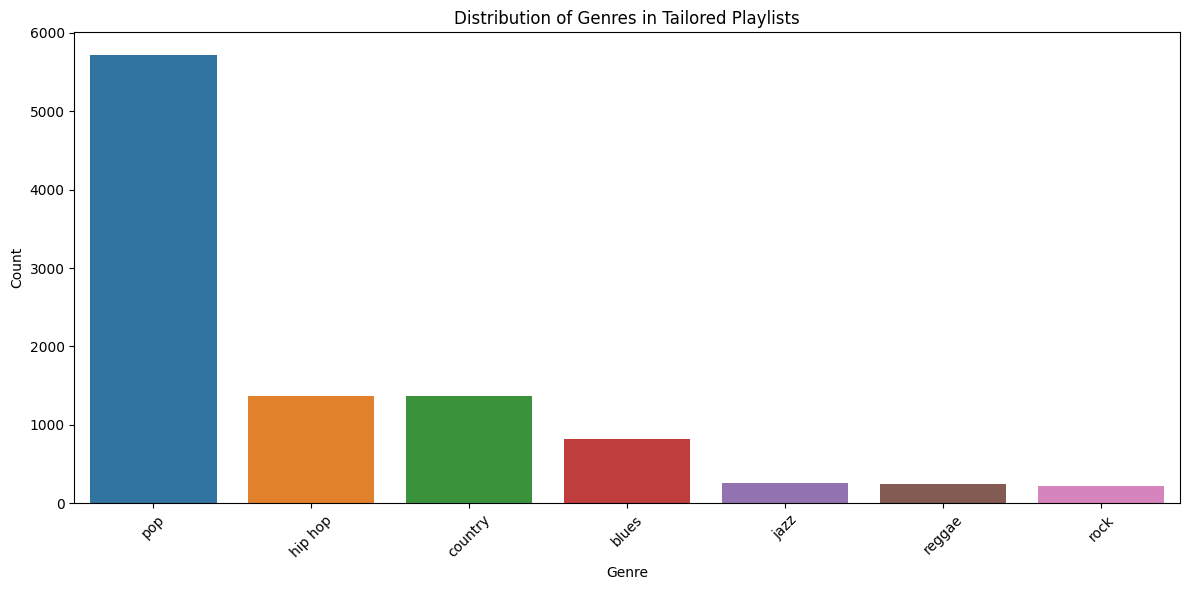

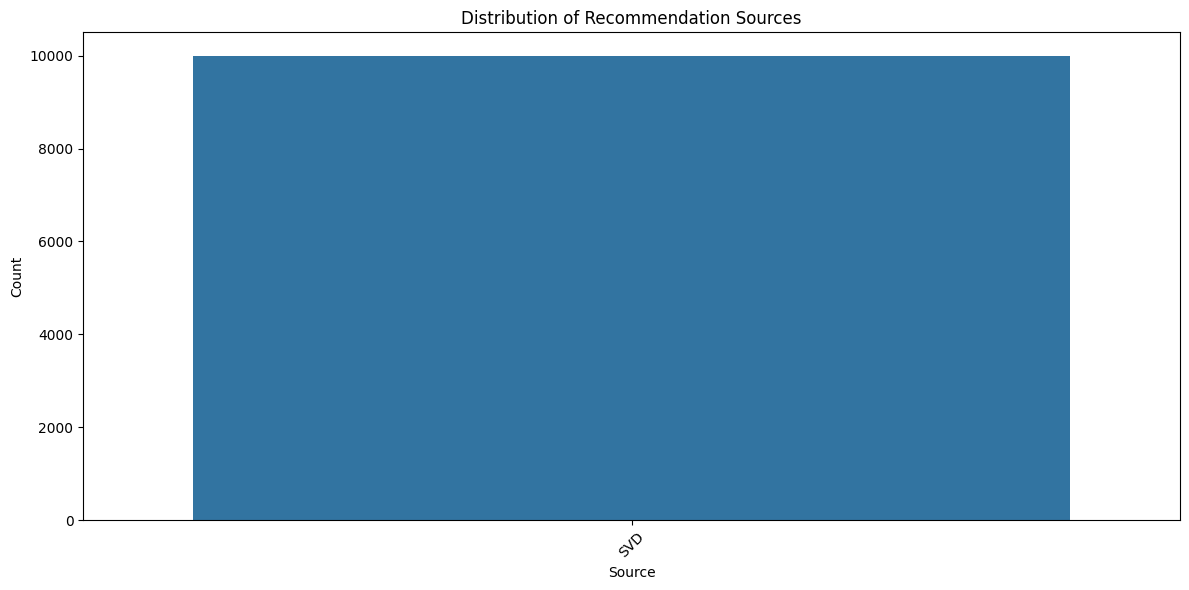

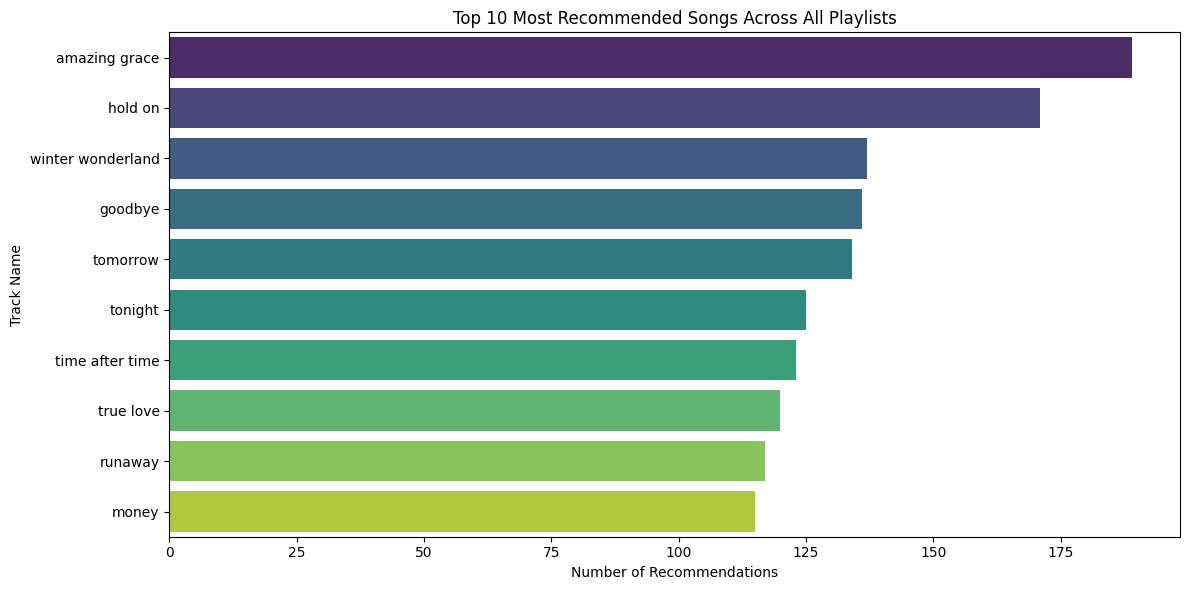

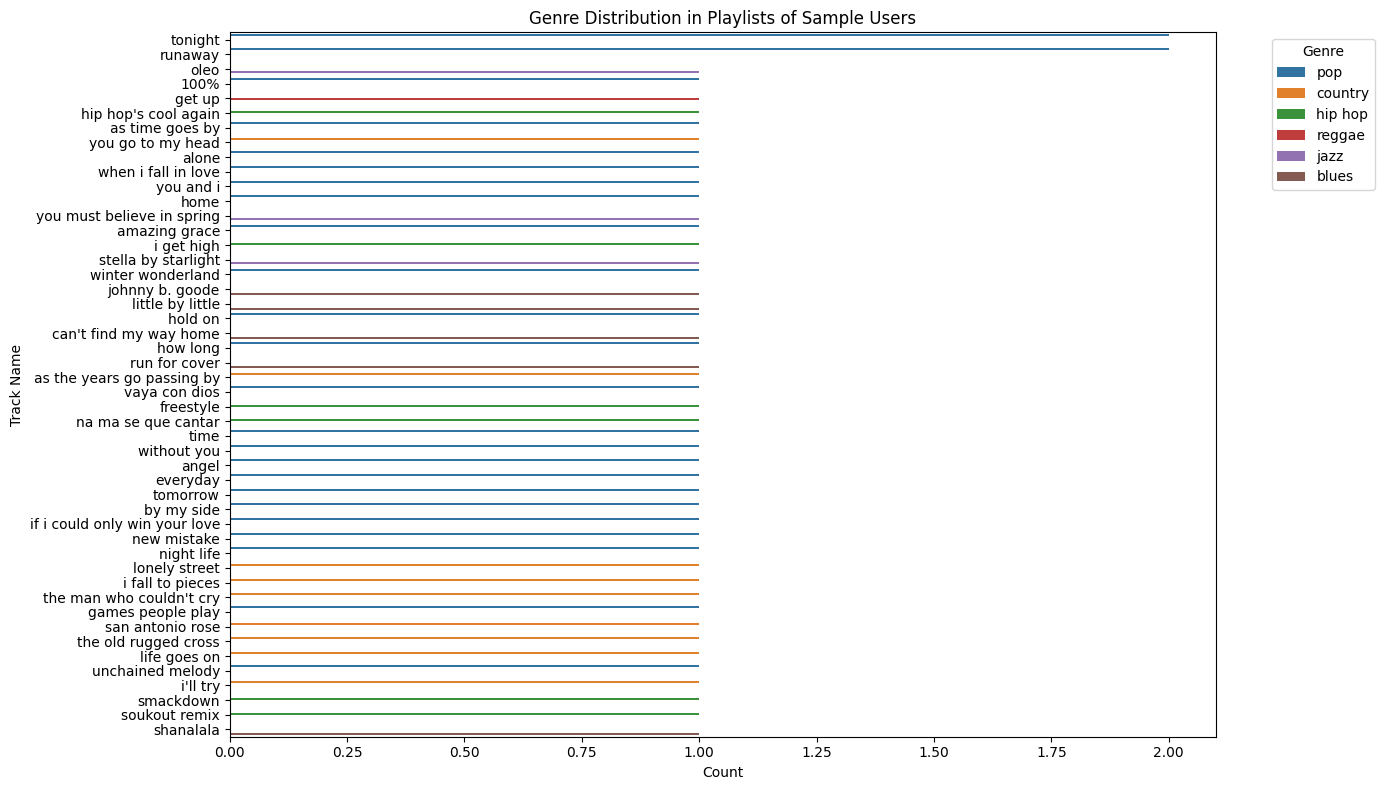

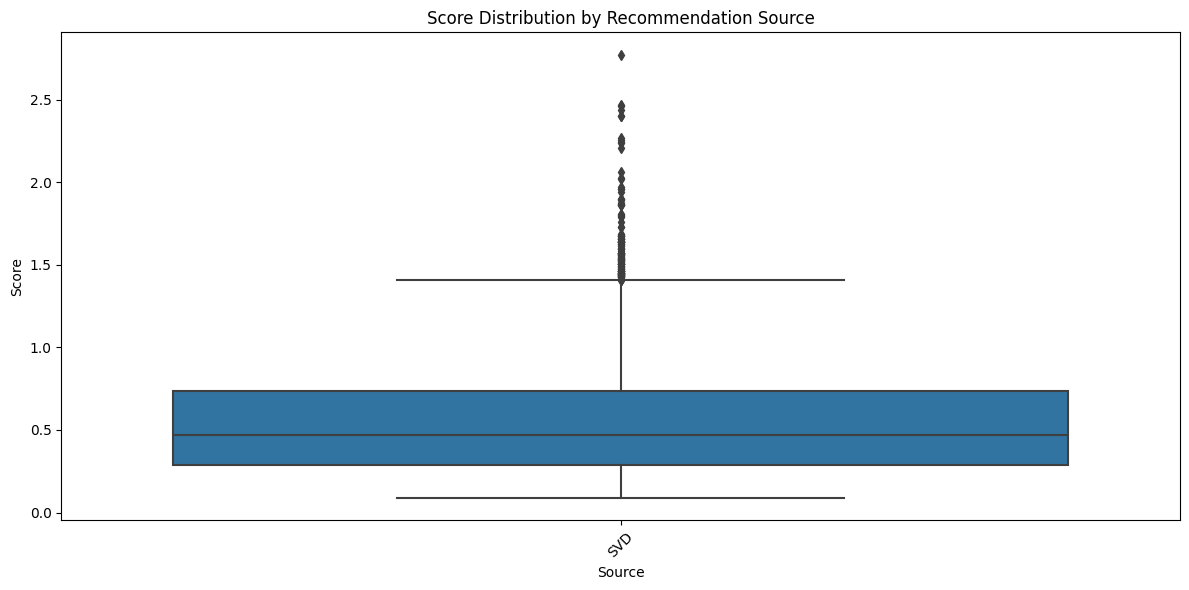

In [25]:
# Load the tailored playlists
tailored_playlists = pd.read_csv('data/tailored_playlists.csv')

# Overview of the dataset
print("Dataset Overview:")
print(tailored_playlists.head())
print("\nColumns in dataset:", tailored_playlists.columns.tolist())

# 1. Distribution of Genres in Playlists
plt.figure(figsize=(12, 6))
sns.countplot(data=tailored_playlists, x='genre', order=tailored_playlists['genre'].value_counts().index)
plt.title('Distribution of Genres in Tailored Playlists')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Distribution of Recommendation Sources
plt.figure(figsize=(12, 6))
sns.countplot(data=tailored_playlists, x='source', order=tailored_playlists['source'].value_counts().index)
plt.title('Distribution of Recommendation Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Top 10 Most Recommended Songs
top_songs = tailored_playlists['track_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')
plt.title('Top 10 Most Recommended Songs Across All Playlists')
plt.xlabel('Number of Recommendations')
plt.ylabel('Track Name')
plt.tight_layout()
plt.show()

# 4. Genre Distribution per User (Sample Visualization)
sample_users = tailored_playlists['user_id'].unique()[:5]  # Sample 5 users
sample_data = tailored_playlists[tailored_playlists['user_id'].isin(sample_users)]

plt.figure(figsize=(14, 8))
sns.countplot(data=sample_data, y='track_name', hue='genre', order=sample_data['track_name'].value_counts().index)
plt.title('Genre Distribution in Playlists of Sample Users')
plt.xlabel('Count')
plt.ylabel('Track Name')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Score Distribution by Source (if score is available)
if 'score' in tailored_playlists.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=tailored_playlists, x='source', y='score')
    plt.title('Score Distribution by Recommendation Source')
    plt.xlabel('Source')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()